In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image


In [3]:
base_path = '/content/drive/MyDrive/Dataset'
images_path = os.path.join(base_path, 'image1')
labels_path = os.path.join(base_path, 'label1')

In [4]:
print("Images folder:", os.listdir(images_path)[:5])  # Show a few image files
print("Labels folder:", os.listdir(labels_path)[:5])  # Show a few label files

Images folder: ['0002.bmp', '0003.bmp', '0001.bmp', '0000.bmp', '0010.bmp']
Labels folder: ['0012.png', '0005.png', '0007.png', '0001.png', '0008.png']


In [5]:
IMG_HEIGHT = 320
IMG_WIDTH = 320
NUM_CLASSES = 2  # Adjust based on the number of classes

# Function to load and resize an image
def load_image(image_path, label_path):
    # Load image and label
    image = Image.open(image_path).convert('RGB')  # Open .bmp image and convert to RGB
    label = Image.open(label_path).convert('L')  # Open .png label, assuming grayscale labels

    # Resize to (320, 320)
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    label = label.resize((IMG_WIDTH, IMG_HEIGHT))

    # Convert to numpy arrays and normalize
    image = np.array(image) / 255.0
    label = np.array(label)

    # Ensure label values are within the valid range (added line)
    label = np.clip(label, 0, NUM_CLASSES - 1)

    # One-hot encode the label if it's segmentation
    label = np.eye(NUM_CLASSES)[label]

    return image, label


In [6]:
def load_dataset(images_folder, labels_folder):
    images = []
    labels = []
    image_files = os.listdir(images_folder)
    label_files = os.listdir(labels_folder)

    for image_file, label_file in zip(image_files, label_files):
        image_path = os.path.join(images_folder, image_file)
        label_path = os.path.join(labels_folder, label_file)

        image, label = load_image(image_path, label_path)
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)


In [7]:
images, labels = load_dataset(images_path, labels_path)

In [8]:
print(f"Loaded {images.shape[0]} images and {labels.shape[0]} labels.")

Loaded 501 images and 501 labels.


In [9]:
# Ghost Module Implementation
def ghost_module(x, output_channels):
    """
    Ghost Module: Creates efficient feature maps using depthwise convolutions.
    """
    ghost1 = layers.Conv2D(output_channels // 2, (1, 1), padding='same')(x)
    ghost1 = layers.BatchNormalization()(ghost1)
    ghost1 = layers.ReLU()(ghost1)

    ghost2 = layers.DepthwiseConv2D((3, 3), padding='same')(ghost1)
    ghost2 = layers.BatchNormalization()(ghost2)
    ghost2 = layers.ReLU()(ghost2)

    return layers.Concatenate()([ghost1, ghost2])

In [10]:
# SE Block Implementation
def se_block(input_tensor, reduction_ratio=4):
    """
    Squeeze-and-Excitation Block.
    """
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape([1, 1, filters])(se)
    return layers.Multiply()([input_tensor, se])

In [11]:
# GSLU-Net Model Implementation
def GSLU_Net(input_shape=(320, 320, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)

    # Encoder path with ghost modules
    conv1 = ghost_module(inputs, 64)
    se1 = se_block(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(se1)

    conv2 = ghost_module(pool1, 128)
    se2 = se_block(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(se2)

    # Bottleneck
    conv3 = ghost_module(pool2, 256)
    se3 = se_block(conv3)

    # Decoder path with ghost modules and upsampling
    up2 = layers.UpSampling2D(size=(2, 2))(se3)
    merge2 = layers.Concatenate()([conv2, up2])
    conv4 = ghost_module(merge2, 128)

    up1 = layers.UpSampling2D(size=(2, 2))(conv4)
    merge1 = layers.Concatenate()([conv1, up1])
    conv5 = ghost_module(merge1, 64)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    # Build the model
    model = models.Model(inputs, outputs)
    return model


In [12]:
# Instantiate the model
model = GSLU_Net()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 320, 320, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 320, 320, 32)   │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 320, 320, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 320, 320, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 320, 320, 32)   │            320 │ re_lu[0][0]            │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 320, 320, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 320, 320, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 320, 320, 64)   │              0 │ re_lu[0][0],           │
│                           │                        │                │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ concatenate[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │          1,040 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          1,088 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 320, 320, 64)   │              0 │ concatenate[0][0],     │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 160, 160, 64)   │              0 │ multiply[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 160, 64)   │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 160, 160, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization) 

 Total params: 101,074 (394.82 KB)

 Trainable params: 99,794 (389.82 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Split into training and validation sets (80% train, 20% validation)
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [59]:
# Training the model
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=20, batch_size=16)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.9669 - loss: 0.1448 - val_accuracy: 0.9671 - val_loss: 0.1553
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - accuracy: 0.9677 - loss: 0.1412 - val_accuracy: 0.9671 - val_loss: 0.1513
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.9652 - loss: 0.1503 - val_accuracy: 0.9671 - val_loss: 0.1484
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - accuracy: 0.9647 - loss: 0.1516 - val_accuracy: 0.9671 - val_loss: 0.1467
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.9675 - loss: 0.1419 - val_accuracy: 0.9671 - val_loss: 0.1464
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.9667 - loss: 0.1444 - val_accuracy: 0.9671 - val_loss: 0.1453
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.9678 - loss: 0.1402 - val_accuracy: 0.9671 - val_loss: 0.1450
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.9679 - loss: 0.1402 - val_accura

In [60]:
# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9669 - loss: 0.1452 
Validation Loss: 0.14355474710464478, Validation Accuracy: 0.9671424627304077


Predicted values for sample 0:
Max: 0.9347028136253357, Min: 0.8845637440681458
Unique values in binary mask: [0 1]


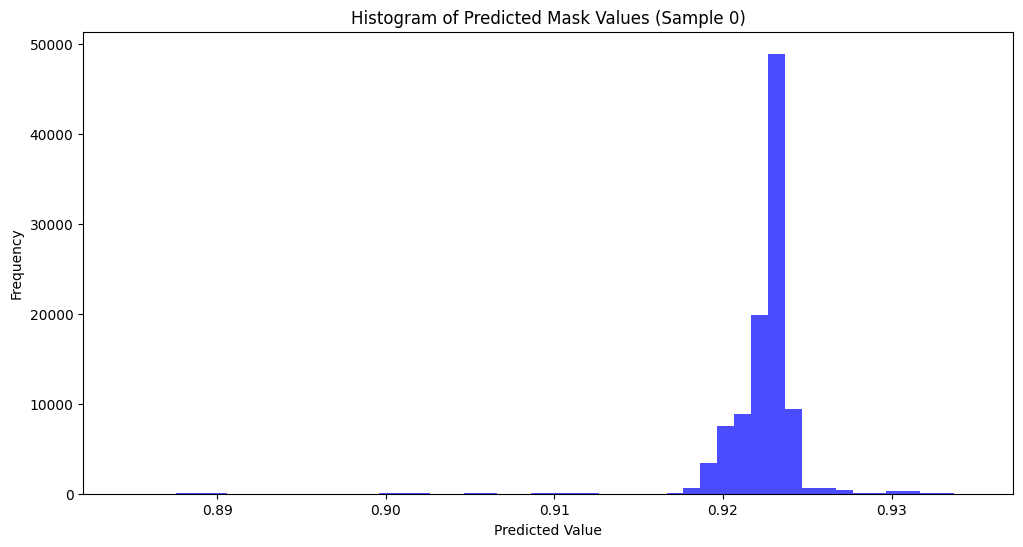

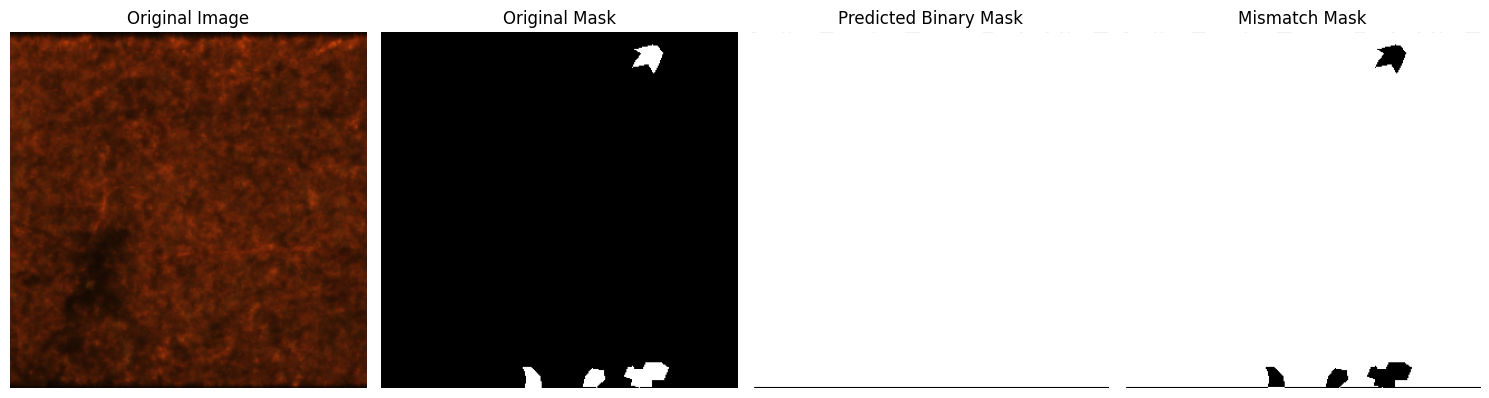

Predicted values for sample 1:
Max: 0.9358879327774048, Min: 0.8836237788200378
Unique values in binary mask: [0 1]


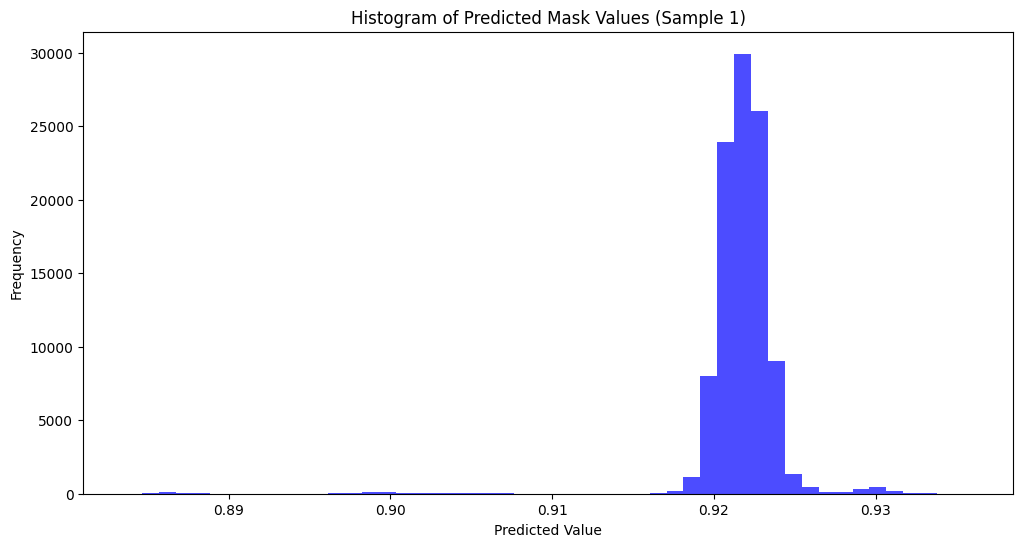

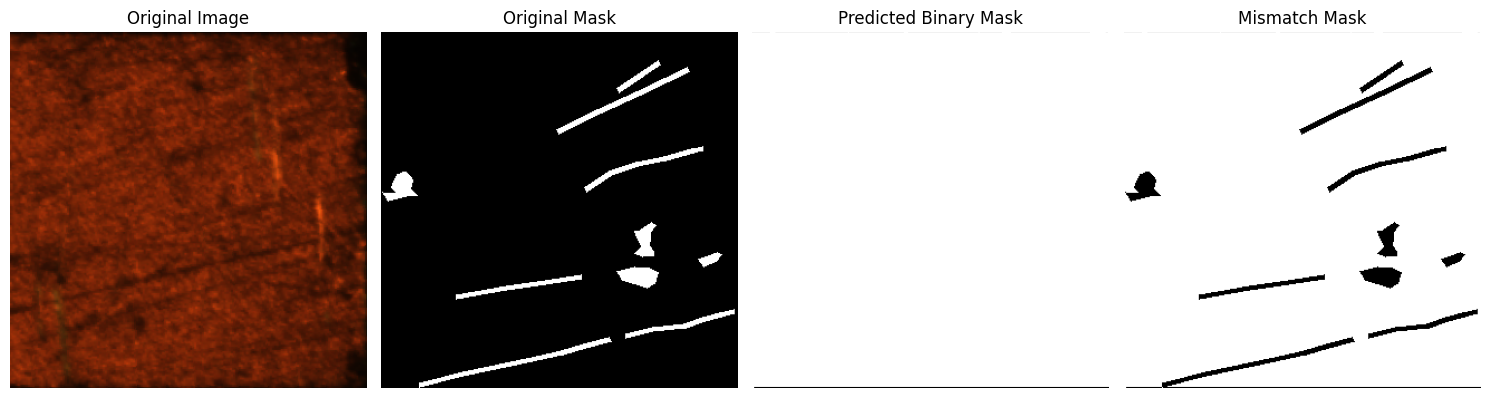

Predicted values for sample 2:
Max: 0.9342507123947144, Min: 0.8841707706451416
Unique values in binary mask: [0 1]


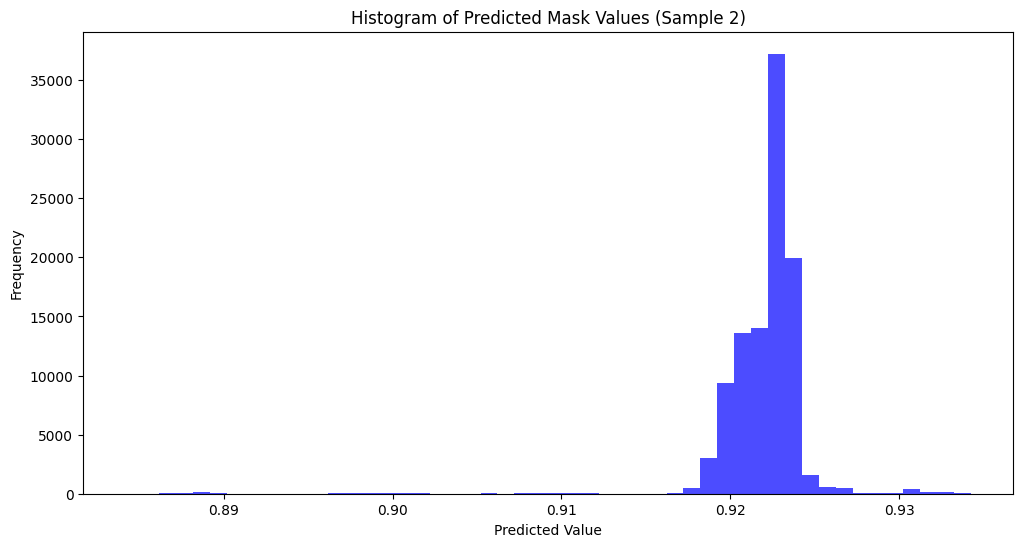

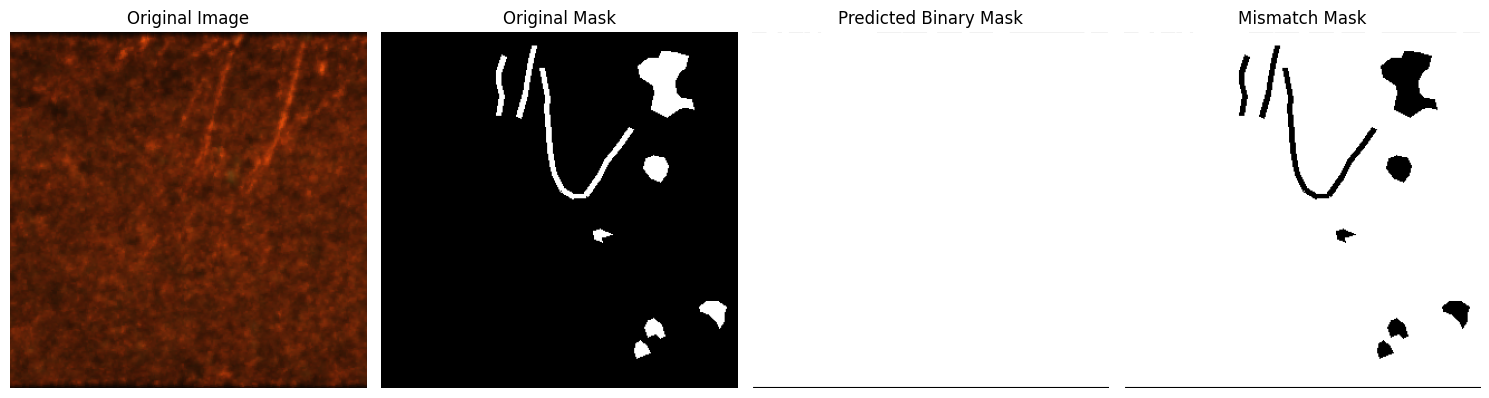

Predicted values for sample 3:
Max: 0.9343066811561584, Min: 0.8845812678337097
Unique values in binary mask: [0 1]


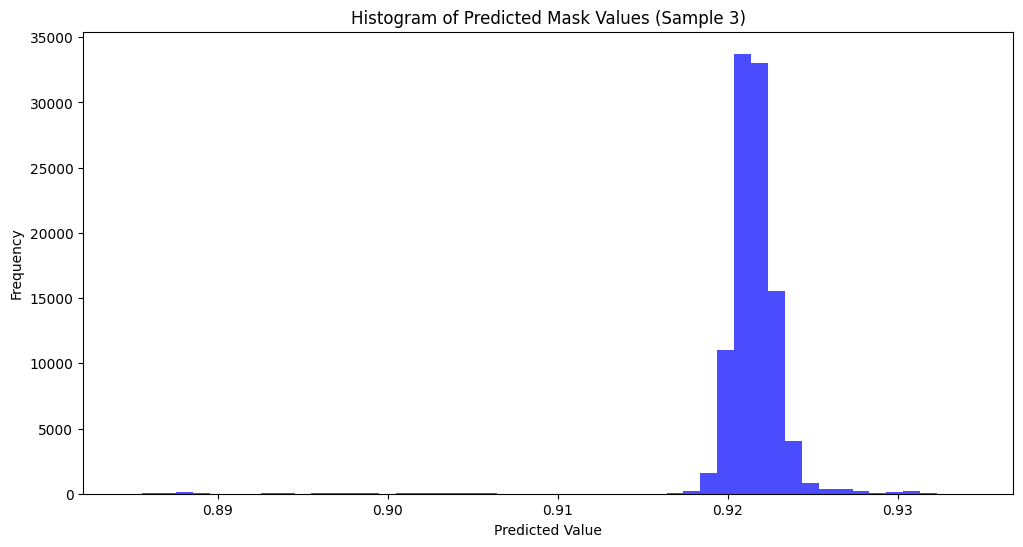

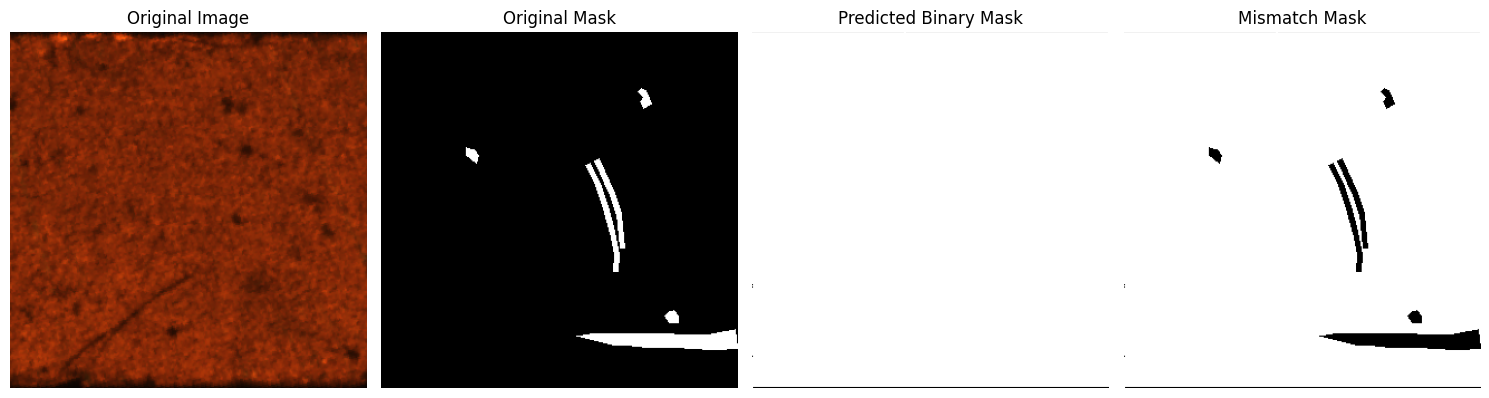

Predicted values for sample 4:
Max: 0.9352811574935913, Min: 0.883491039276123
Unique values in binary mask: [0 1]


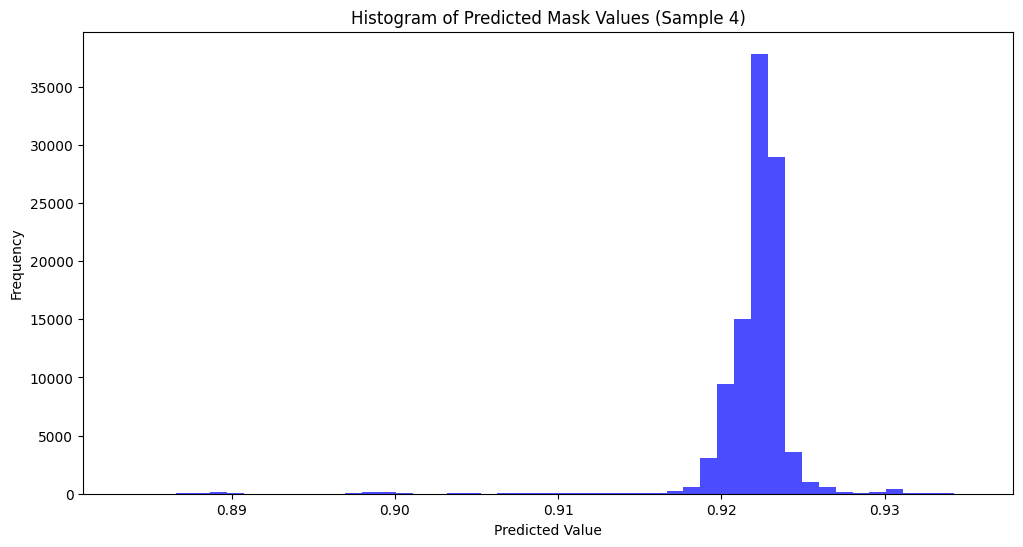

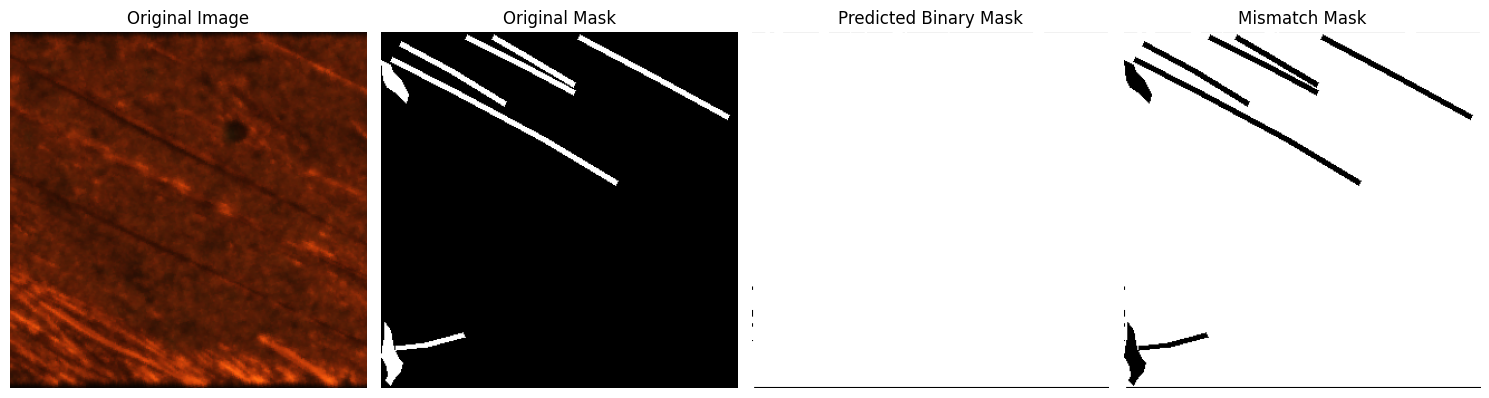

In [71]:
# Function to binarize a mask
def binarize_mask(mask, threshold=0.9):
    return (mask >= threshold).astype(np.uint8)  # Ensure binary output (0 or 1)


def visualize_predictions_with_histogram(images, labels, predictions, num_samples=5, threshold=0.9):
    for i in range(min(num_samples, len(images))):
        original_image = images[i]
        original_mask = labels[i].argmax(axis=-1)  # Convert one-hot encoding to single channel
        predicted_mask = predictions[i].max(axis=-1)  # Take the max confidence for thresholding
        binary_predicted_mask = binarize_mask(predicted_mask, threshold)  # Binarize mask

        # Debugging: Print and plot histogram of predicted values
        print(f"Predicted values for sample {i}:")
        print(f"Max: {predicted_mask.max()}, Min: {predicted_mask.min()}")
        print(f"Unique values in binary mask: {np.unique(binary_predicted_mask)}")

        # Plot histogram of predicted mask values
        plt.figure(figsize=(12, 6))
        plt.hist(predicted_mask.flatten(), bins=50, color='blue', alpha=0.7)
        plt.title(f"Histogram of Predicted Mask Values (Sample {i})")
        plt.xlabel("Predicted Value")
        plt.ylabel("Frequency")
        plt.show()

        # Plot original image, masks, and binary prediction
        plt.figure(figsize=(15, 10))

        plt.subplot(1, 4, 1)
        plt.title("Original Image")
        plt.imshow(original_image)
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Original Mask")
        plt.imshow(original_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Predicted Binary Mask")
        plt.imshow(binary_predicted_mask, cmap='gray', vmin=0, vmax=1)  # Ensure binary mask is visualized correctly
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Mismatch Mask")
        mismatch_mask = (binary_predicted_mask != original_mask).astype(np.uint8)
        plt.imshow(mismatch_mask, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Visualize with histograms
visualize_predictions_with_histogram(val_images, val_labels, val_predictions, num_samples=5, threshold=0.9)


In [ ]:
model.save('/content/drive/MyDrive/GSLU_Net_model_RGB.h5')
